# Verification experiment - NARMAX

I generate data according to a NARMAX model and recover parameters using both a FEM estimator and an RLS estimator. 

The estimators are validated with a simulation error experiment.

In [207]:
using Revise
using ProgressMeter
using LinearAlgebra
using JLD
using MAT
using Plots
pyplot();

#### Experimental parameters

In [208]:
# Length of transient period
transient = 0

# Length of training signal
ix_trn = collect(1:512) .+ transient

# Length of testing signal
ix_tst = collect(1:1000) .+ transient

# Number of VMP iterations
num_iters = 5;

## Data

#### System parameters

In [209]:
# # Polynomial degrees
# deg_t = 3

# # True orders
# M1_t = 3
# M2_t = 3
# M3_t = 3
# M_t = M1_t + 1 + M2_t + M3_t

# # Number of coefficients
# N_t = M_t*deg_t + 1

# # True basis function
# PΨ = zeros(M_t,0); for d=1:deg_t; PΨ = hcat(d .*Matrix{Float64}(I,M_t,M_t), PΨ); end
# ψ(x::Array{Float64,1}) = [prod(x.^PΨ[:,k]) for k = 1:size(PΨ,2)];

# # Parameters
# τ_true = 1e6
# θ_true = .5 .*(rand(N_t,) .- 0.5);
# θ_true[end] = 0.;

#### Model parameters

In [210]:
# Polynomial degree
# deg_m = 3;

# # Model orders
# M1_m = 3
# M2_m = 3
# M3_m = 3
# M_m = M1_m + 1 + M2_m + M3_m

# Number of coefficients after basis expansion
# N_m = M_m*deg_m + 1;

# # Model basis function
# PΦ = zeros(M_m,1); for d=1:deg_m; PΦ = hcat(d .*Matrix{Float64}(I,M_m,M_m), PΦ); end
# ϕ(x::Array{Float64,1}) = [prod(x.^PΦ[:,k]) for k = 1:size(PΦ,2)];

#### Generate input

In [211]:
# include("fMultiSinGen.jl")

# # Parameters
# num_periods = 10
# points_period = 1000
# num_real = 1
# fMin = 0.0
# fMax = 100.0
# fs = 10 .* fMax
# uStd = 0.1

# # Input frequency and amplitude
# input, inputfreq = fMultiSinGen(points_period, 
#                                 num_periods, 
#                                 num_real, 
#                                 fMin=fMin, 
#                                 fMax=fMax, 
#                                 fs=fs, 
#                                 type_signal="odd", 
#                                 uStd=uStd);

# # Scale down
# # input /= 10.;

In [212]:
# plot(input, color="red", label="input")

In [213]:
# savefig("figures/NARMAX-generated-input_deg"*string(deg_t)*"_order"*string(M_t)*".png")

In [214]:
# ix_zoom = 100:300
# plot(ix_zoom, input[ix_zoom], color="red", label="input", xlabel="time [k]", ylabel="signal")

In [215]:
# savefig("figures/NARMAX-generated-input_deg"*string(deg_t)*"_order"*string(M_t)*"_zoom100-300.png")

#### Generate output

In [216]:
# # Observation array
# output = zeros(T,)
# errors = zeros(T,)

# for k = 1:T

#     # Generate noise
#     errors[k] = sqrt(inv(τ_true))*randn(1)[1]

#     # Output
#     if k < (maximum([M1_t, M2_t, M3_t])+1)
#         output[k] = input[k] + errors[k]
#     else
#         # Update history vectors
#         x_kmin1 = output[k-1:-1:k-M1_t]
#         z_kmin1 = input[k-1:-1:k-M2_t]
#         r_kmin1 = errors[k-1:-1:k-M3_t]

#         # Compute output
#         output[k] = θ_true'*ψ([x_kmin1; input[k]; z_kmin1; r_kmin1]) + errors[k]
#     end
# end

# # Y-Limits of output signal
# ylims = [minimum(output[tt:T]), maximum(output[tt:T])];

In [217]:
# plot(output[tt:T], color="black", label="output")

In [218]:
# savefig("figures/NARMAX-generated-output_deg"*string(deg_t)*"_order"*string(M_t)*".png")

In [219]:
# plot(input[tt:T], color="red", label="input")
# plot!(output[tt:T], color="black", label="output")

In [220]:
# savefig("figures/NARMAX-generated-input+output_deg"*string(deg_t)*"_order"*string(M_t)*".png")

In [221]:
# # Visualize signal
# zoom_t = 200:400
# p101 = plot(zoom_t, input[zoom_t], color="red", label="input", xlabel="time [k]", ylabel="", size=(600,220))
# plot!(zoom_t, output[zoom_t], color="black", label="output", legend=:topleft)

In [222]:
# savefig(p101, "figures/NARMAX-generated-input+output_deg"*string(deg_t)*"_order"*string(M_t)*"_zoom200-400.png")

### Load matlab code

In [223]:
mat_data = matread("data/NARMAXsignal_r1.mat")
input_trn = mat_data["uTrain"][ix_trn]
input_tst = mat_data["uTest"][ix_tst]
output_trn = mat_data["yTrain"][ix_trn]
output_tst = mat_data["yTest"][ix_tst]

M1_m = convert(Int64, mat_data["options"]["nb"])
M2_m = convert(Int64, mat_data["options"]["na"])
M3_m = convert(Int64, mat_data["options"]["ne"])
deg_m = convert(Int64, mat_data["options"]["nd"])

M_m = M1_m + 1 + M2_m + M3_m
N_m = M_m*deg_m;

θ_true = mat_data["theta"]
τ_true = inv(mat_data["options"]["stde"].^2)

# Model basis function
PΦ = zeros(M_m,0); for d=1:deg_m; PΦ = hcat(d .*Matrix{Float64}(I,M_m,M_m), PΦ); end
ϕ(x::Array{Float64,1}) = [prod(x.^PΦ[:,k]) for k = 1:size(PΦ,2)];

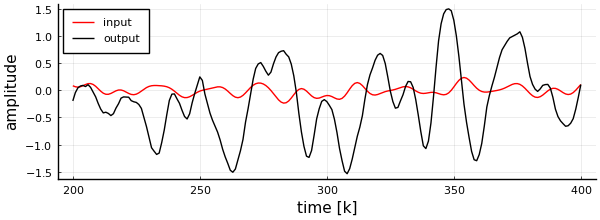

In [224]:
# Visualize signal
zoom_t = 200:400
p101 = plot(zoom_t, input_trn[zoom_t], color="red", label="input", xlabel="time [k]", ylabel="amplitude", size=(600,220))
plot!(zoom_t, output_trn[zoom_t], color="black", label="output", legend=:topleft)

In [225]:
savefig("figures/NARMAX-generated-input+output_deg"*string(deg_m)*"_order"*string(M_m)*"_zoom"*string(zoom_t[1])*"-"*string(zoom_t[end])*".png")

## Model specification

In [226]:
using ForneyLab
import ForneyLab: unsafeMean, unsafeCov, unsafeMeanCov
using NARMAX

In [227]:
graph = FactorGraph()

# Observed variables
@RV y_kmin1; placeholder(y_kmin1, :y_kmin1, dims=(M1_m,))
@RV u_kmin1; placeholder(u_kmin1, :u_kmin1, dims=(M2_m,))
@RV e_kmin1; placeholder(e_kmin1, :e_kmin1, dims=(M3_m,))
@RV u_k; placeholder(u_k, :u_k)

# Time-invariant parameters
@RV τ ~ Gamma(placeholder(:a_τ), placeholder(:b_τ))
@RV θ ~ GaussianMeanVariance(placeholder(:m_θ, dims=(N_m,)), placeholder(:v_θ, dims=(N_m, N_m)))

# Likel7ihood
@RV y_k ~ NAutoRegressiveMovingAverageX(θ, y_kmin1, u_k, u_kmin1, e_kmin1, τ, g=ϕ)
placeholder(y_k, :y_k)

# ForneyLab.draw(graph)

# Compile message passing procedure
q = PosteriorFactorization(θ, τ, ids=[:θ :τ])
algorithm = messagePassingAlgorithm([θ; τ], q, free_energy=true)
source_code = algorithmSourceCode(algorithm, free_energy=true)
eval(Meta.parse(source_code));

## Inference

In [228]:
# Initialize priors
θ_k = (zeros(N_m,), 10 .*Matrix{Float64}(I,N_m,N_m))
# θ_k = (θ_true[:,1], 10. .*Matrix{Float64}(I, N_m, N_m))
τ_k = (1e4, 1e0);

In [229]:
# Initialize marginals
marginals = Dict(:θ => ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=θ_k[1], v=θ_k[2]),
                 :τ => ProbabilityDistribution(Univariate, Gamma, a=τ_k[1], b=τ_k[2]))

# Maximum delay
maxM = maximum([M1_m, M2_m, M3_m])

# Zero-padding of signals
input_trn = [zeros(maxM,); input_trn]
input_tst = [zeros(maxM,); input_tst]
output_trn = [zeros(maxM,); output_trn]
output_tst = [zeros(maxM,); output_tst]

# Signal splits
T_trn = length(input_trn)
T_tst = length(input_tst)

"Inference execution"

# Preallocate free energy array
Fq = zeros(T_trn-maxM, num_iters)

# Preallocate parameter arrays
params_θ = (zeros(T_trn-maxM,N_m), zeros(T_trn-maxM,N_m,N_m))
params_τ = (zeros(T_trn-maxM,1), zeros(T_trn-maxM,1))

# Preallocate prediction arrays
predictions_FEM = (zeros(T_trn,), zeros(T_trn,))
errors = zeros(T_trn,)

@showprogress for (ii,k) in enumerate(maxM+1:T_trn)

    # Update history vectors
    y_kmin1 = output_trn[k-1:-1:k-M1_m]
    u_kmin1 = input_trn[k-1:-1:k-M2_m]
    e_kmin1 = errors[k-1:-1:k-M3_m]

    ϕx = ϕ([y_kmin1; input_trn[k]; u_kmin1; e_kmin1])
    predictions_FEM[1][k] = θ_k[1]'*ϕx
    predictions_FEM[2][k] = ϕx'*θ_k[2]'*ϕx + inv(τ_k[1]/τ_k[2])

    # Compute prediction error
    errors[k] = output_trn[k] - predictions_FEM[1][k]

    # Set data 
    data = Dict(:y_k => output_trn[k],
                :u_k => input_trn[k],
                :y_kmin1 => y_kmin1,
                :u_kmin1 => u_kmin1,
                :e_kmin1 => e_kmin1,
                :m_θ => θ_k[1],
                :v_θ => θ_k[2],
                :a_τ => τ_k[1],
                :b_τ => τ_k[2])

    # Iterate updates
    for n = 1:num_iters

        # Compute free energy
        Fq[ii,n] = freeEnergy(data,marginals)

        # Update parameters
        stepθ!(data, marginals)
        stepτ!(data, marginals)

    end 

    # Update params
    θ_k = (unsafeMean(marginals[:θ]), unsafeCov(marginals[:θ]))
    τ_k = (marginals[:τ].params[:a], marginals[:τ].params[:b])

    # Store params
    params_θ[1][ii,:] = θ_k[1]
    params_θ[2][ii,:,:] = θ_k[2]
    params_τ[1][ii] = τ_k[1]
    params_τ[2][ii] = τ_k[2]

end

Progress:   3%|█▎                                       |  ETA: 0:00:15

LoadError: DomainError with -5.067813164137743e-106:
log will only return a complex result if called with a complex argument. Try log(Complex(x)).

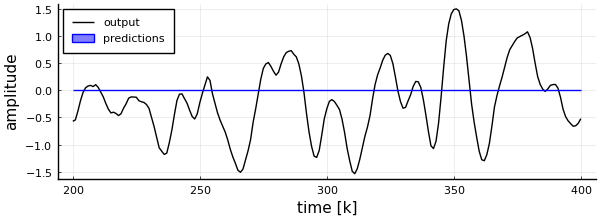

In [230]:
# Visualize signal
zoom_t = 200:400
p101 = plot(zoom_t, output_trn[zoom_t], color="black", label="output", xlabel="time [k]", ylabel="amplitude", size=(600,220))
plot!(zoom_t, predictions_FEM[1][zoom_t], ribbon=[sqrt.(predictions_FEM[2][zoom_t]), sqrt.(predictions_FEM[2][zoom_t])], color="blue", label="predictions", legend=:topleft)

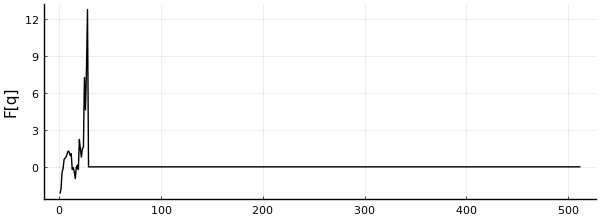

In [231]:
plot(Fq[:,end], color="black", ylabel="F[q]", label="", size=(600,220))

In [232]:
# save("results/FE-NARMAX_FEM_M"*string(M_m)*"_degree"*string(deg_m)*"_S"*string(ts-tt)*".jld", "FE", Fq)

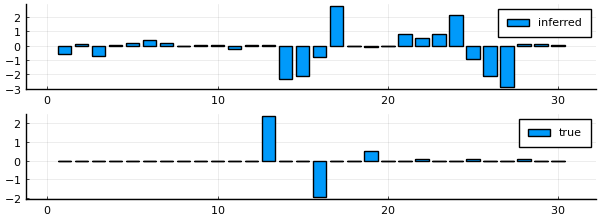

In [233]:
p55a = bar(θ_k[1], label="inferred")
p55b = bar(θ_true, label="true")
p55 = plot(p55a, p55b, layout=(2,1), size=(600,220))

### Forecast

In [234]:
"1-step ahead prediction"

# Prepare array
predictions_FEM = (zeros(T_tst,), zeros(T_tst,))
errors = zeros(T_tst,)

@showprogress for k in maxM+1:T_tst

    # Update history vectors
    y_kmin1 = output_tst[k-1:-1:k-M1_m]
    u_kmin1 = input_tst[k-1:-1:k-M2_m]
    e_kmin1 = errors[k-1:-1:k-M3_m]

    # Posterior predictive
    ϕx = ϕ([y_kmin1; input_tst[k]; u_kmin1; e_kmin1])
    predictions_FEM[1][k] = θ_k[1]'*ϕx
    predictions_FEM[2][k] = ϕx'*θ_k[2]*ϕx + inv(τ_k[1] / τ_k[2])

    # Update error
    errors[k] = output_tst[k] - predictions_FEM[1][k]

end

# Compute root mean square error
RMS_prd_FEM = sqrt(mean((predictions_FEM[1][maxM+1:end] - output_tst[maxM+1:end]).^2))

NaN

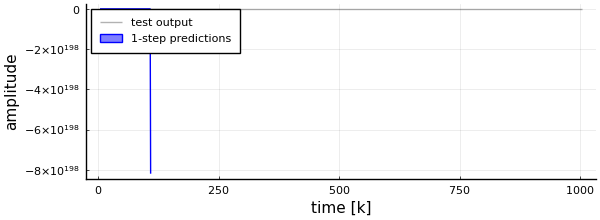

In [235]:
zoom_t = maxM+1:T_tst
p150 = plot(zoom_t, output_tst[zoom_t], color="black", linewidth=1, alpha=0.3, label="test output", xlabel="time [k]", ylabel="amplitude", size=(600,220), legend=:topleft)
plot!(zoom_t, predictions_FEM[1][zoom_t], ribbon=[sqrt.(predictions_FEM[2][zoom_t]), sqrt.(predictions_FEM[2][zoom_t])], color="blue", label="1-step predictions")

In [236]:
savefig(p150, "figures/NARMAX-1steppredictions_deg"*string(deg_m)*"_order"*string(M_m)*"_FEM.png")

In [237]:
"Simulation"

# Prepare array
simulations_FEM = (zeros(T_tst,), zeros(T_tst,))

@showprogress for k in maxM+1:T_tst

    # Update history vectors
    y_kmin1 = simulations_FEM[1][k-1:-1:k-M1_m]
    u_kmin1 = input_tst[k-1:-1:k-M2_m]
    e_kmin1 = zeros(M3_m,)

    # Posterior predictive
    ϕx = ϕ([y_kmin1; input_tst[k]; u_kmin1; e_kmin1])
    simulations_FEM[1][k] = θ_k[1]'*ϕx
    simulations_FEM[2][k] = ϕx'*θ_k[2]*ϕx + inv(τ_k[1] / τ_k[2])

end

# Compute root mean squared error
RMS_sim_FEM = sqrt(mean((simulations_FEM[1][maxM+1:end] - output_tst[maxM+1:end]).^2))

NaN

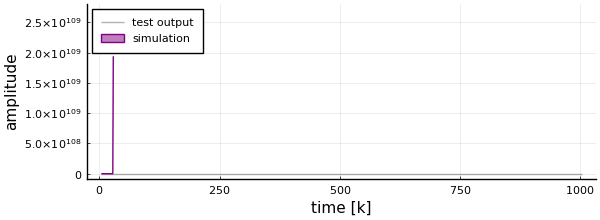

In [238]:
zoom_t = maxM+1:T_tst
p210 = plot(zoom_t, output_tst[zoom_t], color="black", linewidth=1, alpha=0.3, label="test output", xlabel="time [k]", ylabel="amplitude", size=(600,220), legend=:topleft)
plot!(zoom_t, simulations_FEM[1][zoom_t], ribbon=[sqrt.(simulations_FEM[2][zoom_t]), sqrt.(simulations_FEM[2][zoom_t])], color="purple", label="simulation")

In [239]:
savefig(p210, "figures/NARMAX-simulation_deg"*string(deg_m)*"_order"*string(M_m)*"_FEM.png")

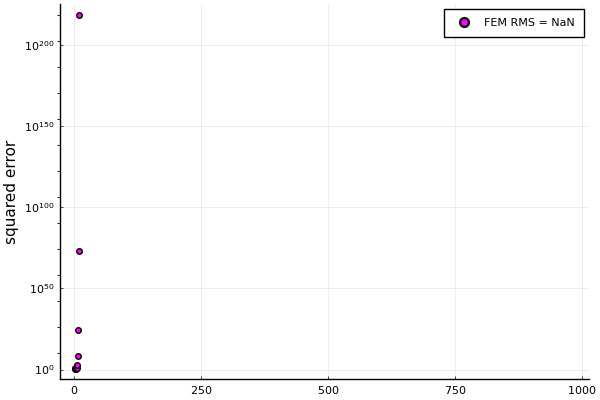

In [240]:
sim_transient = 20
sqerror_sim_FEM = (simulations_FEM[1][sim_transient:end] .- output_tst[sim_transient:end]).^2

scatter(sqerror_sim_FEM, label="FEM RMS = "*string(RMS_sim_FEM), color="magenta", ylabel="squared error", yscale=:log10)

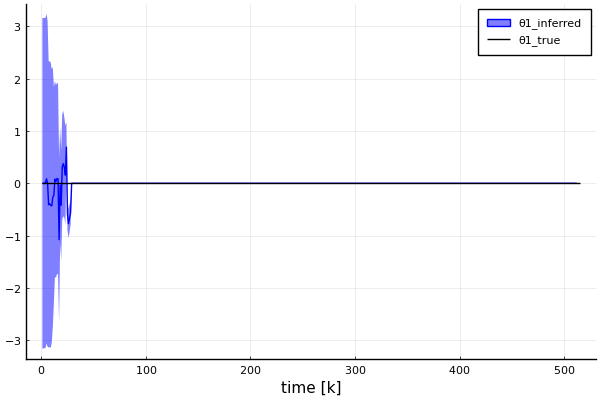

In [241]:
plot(params_θ[1][:,1], ribbon=[sqrt.(params_θ[2][:,1,1]) sqrt.(params_θ[2][:,1,1])], color="blue", xlabel="time [k]", label="θ1_inferred")
plot!(θ_true[1]*ones(T_trn,), color="black", label="θ1_true")

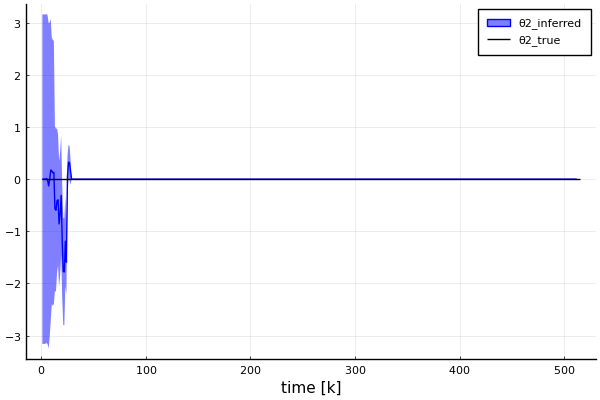

In [242]:
plot(params_θ[1][:,2], ribbon=[sqrt.(params_θ[2][:,2,2]) sqrt.(params_θ[2][:,2,2])], color="blue", xlabel="time [k]", label="θ2_inferred")
plot!(θ_true[2]*ones(T_trn,), color="black", label="θ2_true")

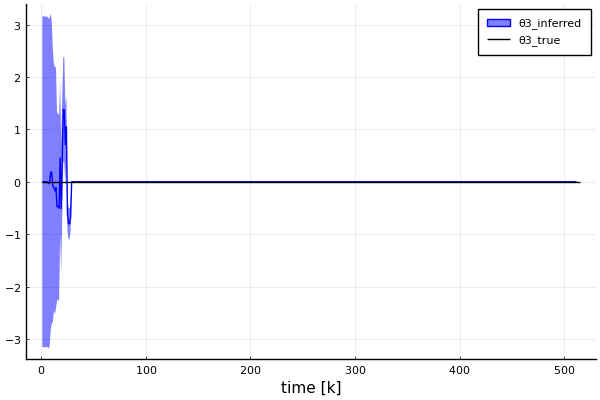

In [243]:
plot(params_θ[1][:,3], ribbon=[sqrt.(params_θ[2][:,3,3]) sqrt.(params_θ[2][:,3,3])], color="blue", xlabel="time [k]", label="θ3_inferred")
plot!(θ_true[3]*ones(T_trn,), color="black", label="θ3_true")

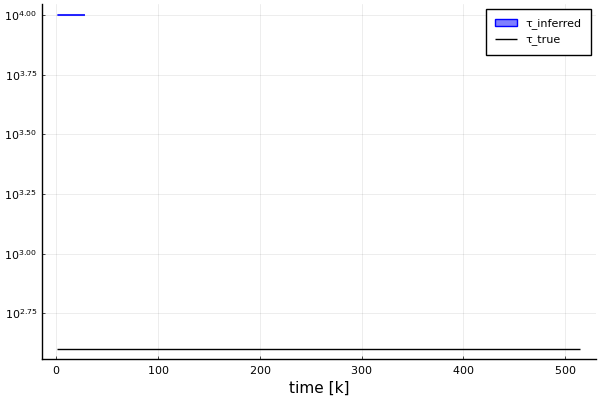

In [244]:
mτ = params_τ[1] ./ params_τ[2]
sτ = sqrt.(params_τ[1] ./ params_τ[2].^2)

plot(mτ, ribbon=[sτ sτ], color="blue", xlabel="time [k]", label="τ_inferred", yscale=:log10)
plot!(τ_true*ones(T_trn,), color="black", label="τ_true")

## Baseline: RLS

Recursive least-squares estimator ([wiki](https://en.wikipedia.org/wiki/Recursive_least_squares_filter#Recursive_algorithm)).

In [245]:
# Forgetting factor
λ = 1.00

# Initialize
P = λ.*Matrix{Float64}(I,N_m,N_m)
w_k = zeros(N_m,)

# Preallocate prediction array
predictions_RLS = zeros(T_trn,)
errors = zeros(T_trn,)

@showprogress for (ii,k) in enumerate(maxM+1:T_trn)

    # Update data vector
    y_kmin1 = output_trn[k-1:-1:k-M1_m]
    u_kmin1 = input_trn[k-1:-1:k-M2_m]
    e_kmin1 = errors[k-1:-1:k-M3_m]
    ϕx = ϕ([y_kmin1; input_trn[k]; u_kmin1; e_kmin1])

    # Update weights
    α = output_trn[k] - w_k'*ϕx 
    g = P*ϕx*inv(λ + ϕx'*P*ϕx)
    P = inv(λ)*P - g*ϕx'*inv(λ)*P
    w_k = w_k + α*g

    # Prediction
    predictions_RLS[k] = w_k'*ϕx
    errors[k] = output_trn[k] - predictions_RLS[k]

end

In [246]:
"1-step ahead prediction"

# Prepare array
predictions_RLS = zeros(T_tst,)
errors = zeros(T_tst,)

for k in maxM+1:T_tst

    # Update history vectors
    y_kmin1 = output_tst[k-1:-1:k-M1_m]
    u_kmin1 = input_tst[k-1:-1:k-M2_m]
    e_kmin1 = errors[k-1:-1:k-M3_m]

    # Point prediction
    ϕx = ϕ([y_kmin1; input_tst[k]; u_kmin1; e_kmin1])
    predictions_RLS[k] = w_k'*ϕx

    # Update error
    errors[k] = output_tst[k] - predictions_RLS[k]

end

RMS_prd_RLS = sqrt(mean((predictions_RLS[maxM+1:end] - output_tst[maxM+1:end]).^2))

0.06473320137218685

In [247]:
"Simulation"

# Prepare array
simulations_RLS = zeros(T_tst,)

for k in maxM+1:T_tst

    # Update history vectors
    y_kmin1 = simulations_RLS[k-1:-1:k-M1_m]
    u_kmin1 = input_tst[k-1:-1:k-M2_m]
    e_kmin1 = zeros(M3_m,)

    # Posterior predictive
    ϕx = ϕ([y_kmin1; input_tst[k]; u_kmin1; e_kmin1])
    simulations_RLS[k] = w_k'*ϕx

end

RMS_sim_RLS = sqrt(mean((simulations_RLS[maxM+1:end] - output_tst[maxM+1:end]).^2))

0.9061002170755111

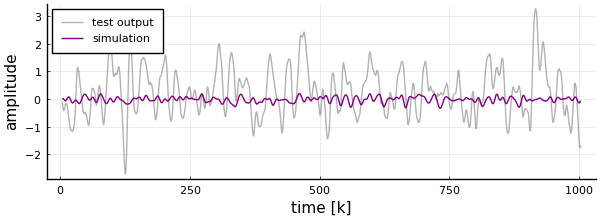

In [248]:
zoom_t = maxM+1:T_tst
p210 = plot(zoom_t, output_tst[zoom_t], color="black", linewidth=1, alpha=0.3, label="test output", xlabel="time [k]", ylabel="amplitude", size=(600,220), legend=:topleft)
plot!(zoom_t, simulations_RLS[zoom_t], color="purple", label="simulation")

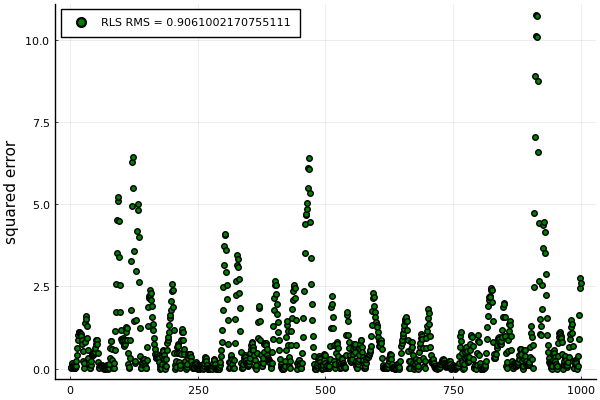

In [249]:
sqerror_RLS = (simulations_RLS[maxM+1:end] - output_tst[maxM+1:end]).^2

scatter(sqerror_RLS, label="RLS RMS = "*string(RMS_sim_RLS), color="green", ylabel="squared error")

## Baseline: ILS

In [250]:
results_ILS = matread("results/results-NARMAX_ILS_M"*string(M_m)*"_degree3_r1.mat")
RMS_prd_ILS = results_ILS["RMS_prd"][2]
RMS_sim_ILS = results_ILS["RMS_sim"][2]

0.1772134749220909

## Comparison

In [251]:
sqerror_FEM = (simulations_FEM[1][100:T_tst] - output_tst[100:T_tst]).^2
sqerror_RLS = (simulations_RLS[100:T_tst] - output_tst[100:T_tst]).^2

RMS_sim_FEM = sqrt(mean(sqerror_FEM))
RMS_sim_RLS = sqrt(mean(sqerror_RLS))

println("RMS FEM = "*string(RMS_sim_FEM))
println("RMS RLS = "*string(RMS_sim_RLS))
println("RMS ILS = "*string(RMS_sim_ILS))

RMS FEM = NaN
RMS RLS = 0.9134637996403779
RMS ILS = 0.1772134749220909


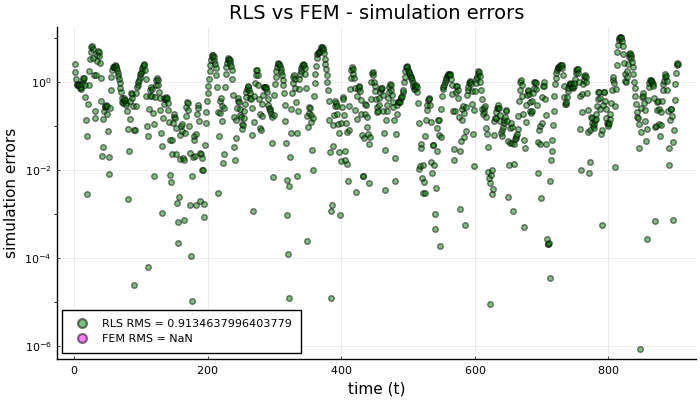

In [252]:
# Comparing simulation errors between PEM and FEM
scatter(sqerror_RLS, 
        color="green", 
        alpha=0.5,
        markersize=4, 
        size=(700,400), 
        yscale=:log10,
        xlabel="time (t)", 
        ylabel="simulation errors",
        label="RLS RMS = "*string(RMS_sim_RLS))
scatter!(sqerror_FEM, 
         color="magenta", 
         alpha=0.5,
         markersize=4,
         labels="FEM RMS = "*string(RMS_sim_FEM),
         title="RLS vs FEM - simulation errors")

In [253]:
savefig("figures/NARMAX-errors_deg"*string(deg_m)*"_order"*string(M_m)*".png")

In [254]:
prop_beaten = mean(sqerror_FEM .< sqerror_RLS)
println("Proportion FEM < RLS = "*string(round(prop_beaten*100))*"%")

Proportion FEM < RLS = 0.0%


In [255]:
sqerror_prd_FEM = (predictions_FEM[1][100:T_tst] - output_tst[100:T_tst]).^2
sqerror_prd_RLS = (predictions_RLS[100:T_tst] - output_tst[100:T_tst]).^2

RMS_prd_FEM = sqrt(mean(sqerror_prd_FEM))
RMS_prd_RLS = sqrt(mean(sqerror_prd_RLS))

println("RMS FEM = "*string(RMS_prd_FEM))
println("RMS RLS = "*string(RMS_prd_RLS))
println("RMS ILS = "*string(RMS_prd_ILS))

RMS FEM = NaN
RMS RLS = 0.06461836596036617
RMS ILS = 0.010741266529060108


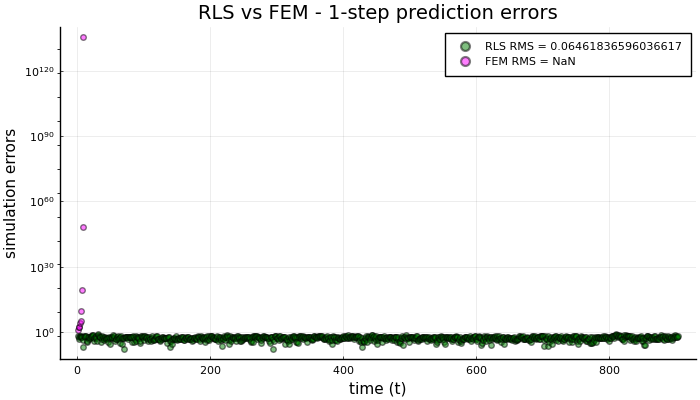

In [256]:
# Comparing simulation errors between PEM and FEM
scatter(sqerror_prd_RLS, 
        color="green", 
        alpha=0.5,
        markersize=4, 
        size=(700,400), 
        yscale=:log10,
        xlabel="time (t)", 
        ylabel="simulation errors",
        label="RLS RMS = "*string(RMS_prd_RLS))
scatter!(sqerror_prd_FEM, 
         color="magenta", 
         alpha=0.5,
         markersize=4,
         labels="FEM RMS = "*string(RMS_prd_FEM),
         title="RLS vs FEM - 1-step prediction errors")

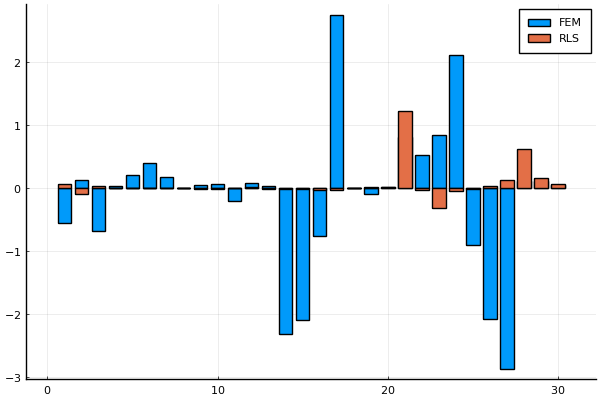

In [257]:
bar(θ_k[1], label="FEM")
bar!(w_k, label="RLS")